----
---

# NYC Taxi Fare Prediction

In [1]:
# Imports

In [2]:
import os

In [3]:
import json

In [4]:
import shutil

In [5]:
import numpy as np

In [6]:
import pandas as pd

In [7]:
import matplotlib.pyplot as plt

In [8]:
import kagglehub

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
from sklearn.ensemble import RandomForestRegressor

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
import joblib

-----

----

In [90]:
#  Download dataset to /content

In [14]:
print("Downloading dataset from KaggleHub...")
dataset_path = kagglehub.dataset_download("dansbecker/new-york-city-taxi-fare-prediction")

100%|██████████| 1.50M/1.50M [00:00<00:00, 105MB/s]

Extracting files...


In [15]:
raw_csv_path = "/content/train.csv"

In [16]:
shutil.copy(os.path.join(dataset_path, "train.csv"), raw_csv_path)

'/content/train.csv'

In [17]:
print("Raw dataset copied to:", raw_csv_path)

Raw dataset copied to: /content/train.csv


---

----

In [89]:
#  Load dataset

In [19]:
df = pd.read_csv(raw_csv_path)

In [20]:
print("Dataset shape:", df.shape)

Dataset shape: (50000, 8)


In [21]:
print(df.head())

                             key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3       

----

----

In [22]:
# Feature Engineering

In [23]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce", utc=True)

In [24]:
df["hour_of_day"]   = df["pickup_datetime"].dt.hour

In [25]:
df["day_of_week"]   = df["pickup_datetime"].dt.dayofweek

In [26]:
df["month"]         = df["pickup_datetime"].dt.month

In [27]:
def haversine_vec(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    miles = 3958.8 * c
    return miles

In [28]:
df["distance_miles"] = haversine_vec(
    df["pickup_longitude"], df["pickup_latitude"],
    df["dropoff_longitude"], df["dropoff_latitude"]
)

In [29]:
#  EDA Filtering clean practical bounds

In [30]:
nyc_lon_min, nyc_lon_max = -75, -72

In [31]:
nyc_lat_min, nyc_lat_max = 40, 42

In [32]:
eda = df[
    (df["pickup_longitude"].between(nyc_lon_min, nyc_lon_max)) &
    (df["dropoff_longitude"].between(nyc_lon_min, nyc_lon_max)) &
    (df["pickup_latitude"].between(nyc_lat_min, nyc_lat_max)) &
    (df["dropoff_latitude"].between(nyc_lat_min, nyc_lat_max)) &
    (df["fare_amount"].between(2.5, 200)) &
    (df["passenger_count"].between(1, 6)) &
    (df["distance_miles"].between(0.01, 100)) &
    df["pickup_datetime"].notna()
].copy()

In [33]:
print("Rows kept for modeling:", eda.shape[0])

Rows kept for modeling: 48105


In [34]:
clean_csv_path = "/content/clean_taxi_data.csv"

In [35]:
eda.to_csv(clean_csv_path, index=False)

In [36]:
print("Clean dataset saved to:", clean_csv_path)

Clean dataset saved to: /content/clean_taxi_data.csv


-----

-----

In [37]:
#  EDA Analysis

In [38]:
avg_by_hour = eda.groupby("hour_of_day")["fare_amount"].mean().round(2)

In [39]:
avg_by_day  = eda.groupby("day_of_week")["fare_amount"].mean().round(2)

In [40]:
print("Average fare by hour\n", avg_by_hour)
print("Average fare by day of week\n", avg_by_day)

Average fare by hour
 hour_of_day
0     11.90
1     11.51
2     11.17
3     11.76
4     13.69
5     15.58
6     12.29
7     11.17
8     10.70
9     10.57
10    10.84
11    11.08
12    11.24
13    11.61
14    12.12
15    12.14
16    12.16
17    11.26
18    11.06
19    10.64
20    10.60
21    11.02
22    10.98
23    11.40
Name: fare_amount, dtype: float64
Average fare by day of week
 day_of_week
0    11.60
1    11.19
2    11.05
3    11.58
4    11.34
5    11.13
6    11.46
Name: fare_amount, dtype: float64


In [41]:
corr_cols = ["fare_amount","distance_miles","passenger_count","hour_of_day","day_of_week","month"]

In [42]:
corr_series = eda[corr_cols].corr()["fare_amount"].sort_values(ascending=False)

In [43]:
print("Correlation with fare\n", corr_series)

Correlation with fare
 fare_amount        1.000000
distance_miles     0.816203
month              0.027986
passenger_count    0.017227
day_of_week       -0.002062
hour_of_day       -0.023103
Name: fare_amount, dtype: float64


In [44]:
avg_by_hour.to_csv("/content/avg_fare_by_hour.csv", header=True)

In [45]:
avg_by_day.to_csv("/content/avg_fare_by_dayofweek.csv", header=True)

In [46]:
eda[corr_cols].corr().to_csv("/content/correlation_matrix.csv")

In [47]:
print("EDA numeric outputs saved to /content as CSVs")

EDA numeric outputs saved to /content as CSVs


----

----

In [48]:
#  EDA Plots

In [49]:
def save_and_show_current_figure(path):
    plt.savefig(path, bbox_inches="tight")
    print("Saved:", path)
    plt.show()
    plt.close()

Saved: /content/fare_distribution.png


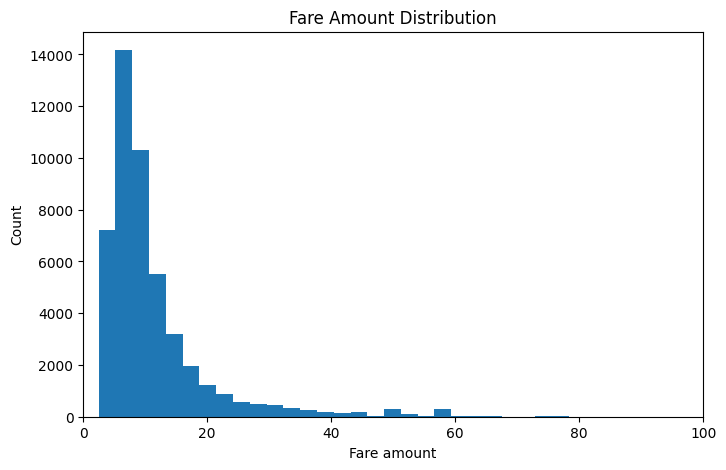

In [50]:
plt.figure(figsize=(8,5))
eda["fare_amount"].plot(kind="hist", bins=60)
plt.title("Fare Amount Distribution")
plt.xlabel("Fare amount")
plt.ylabel("Count")
plt.xlim(0, 100)
save_and_show_current_figure("/content/fare_distribution.png")

Saved: /content/passenger_count_distribution.png


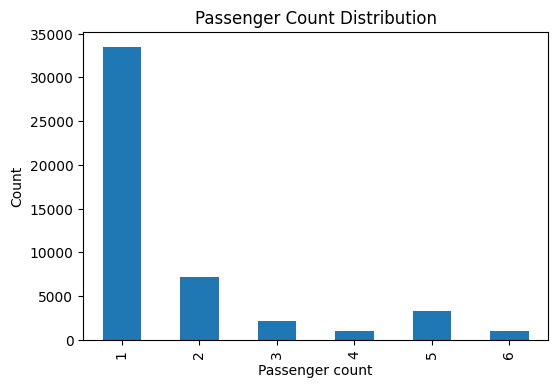

In [51]:
plt.figure(figsize=(6,4))
eda["passenger_count"].value_counts().sort_index().plot(kind="bar")
plt.title("Passenger Count Distribution")
plt.xlabel("Passenger count")
plt.ylabel("Count")
save_and_show_current_figure("/content/passenger_count_distribution.png")

Saved: /content/distance_distribution.png


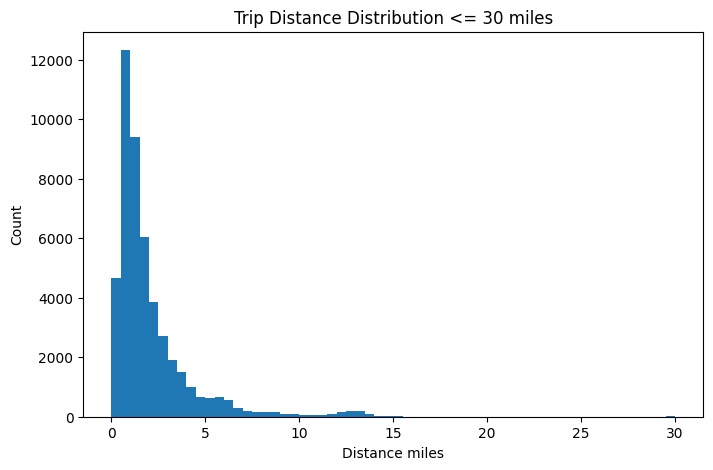

In [52]:
plt.figure(figsize=(8,5))
eda["distance_miles"].clip(upper=30).plot(kind="hist", bins=60)
plt.title("Trip Distance Distribution <= 30 miles")
plt.xlabel("Distance miles")
plt.ylabel("Count")
save_and_show_current_figure("/content/distance_distribution.png")

Saved: /content/fare_vs_distance.png


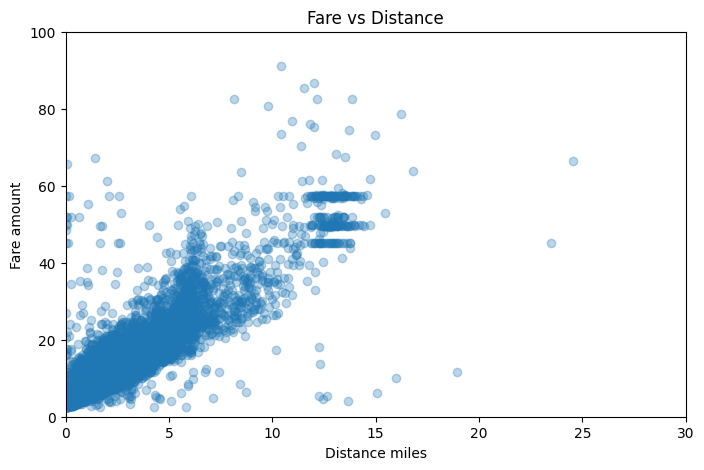

In [53]:
plt.figure(figsize=(8,5))
sample = eda.sample(min(15000, len(eda)), random_state=42)
plt.scatter(sample["distance_miles"], sample["fare_amount"], alpha=0.3)
plt.title("Fare vs Distance")
plt.xlabel("Distance miles")
plt.ylabel("Fare amount")
plt.xlim(0, 30)
plt.ylim(0, 100)
save_and_show_current_figure("/content/fare_vs_distance.png")

Saved: /content/avg_fare_by_hour.png


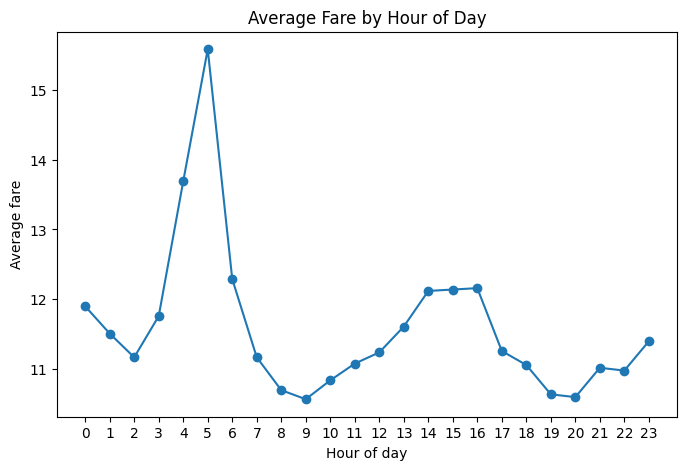

In [54]:
plt.figure(figsize=(8,5))
avg_by_hour.plot(kind="line", marker="o")
plt.title("Average Fare by Hour of Day")
plt.xlabel("Hour of day")
plt.ylabel("Average fare")
plt.xticks(range(0,24))
save_and_show_current_figure("/content/avg_fare_by_hour.png")

Saved: /content/avg_fare_by_day.png


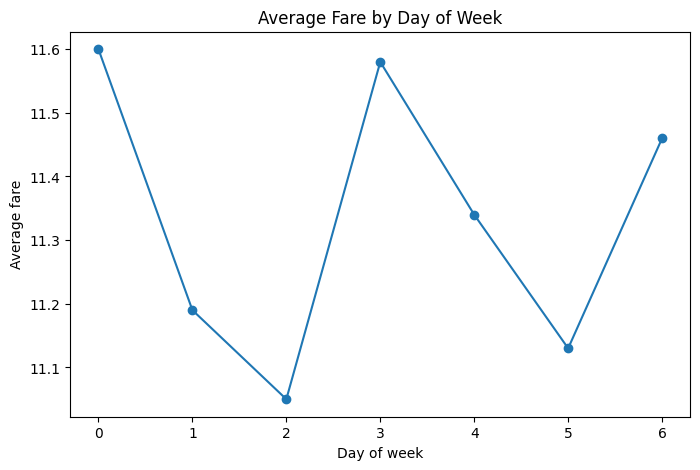

In [55]:
plt.figure(figsize=(8,5))
avg_by_day.plot(kind="line", marker="o")
plt.title("Average Fare by Day of Week")
plt.xlabel("Day of week")
plt.ylabel("Average fare")
plt.xticks(range(0,7))
save_and_show_current_figure("/content/avg_fare_by_day.png")

Saved: /content/pickup_density.png


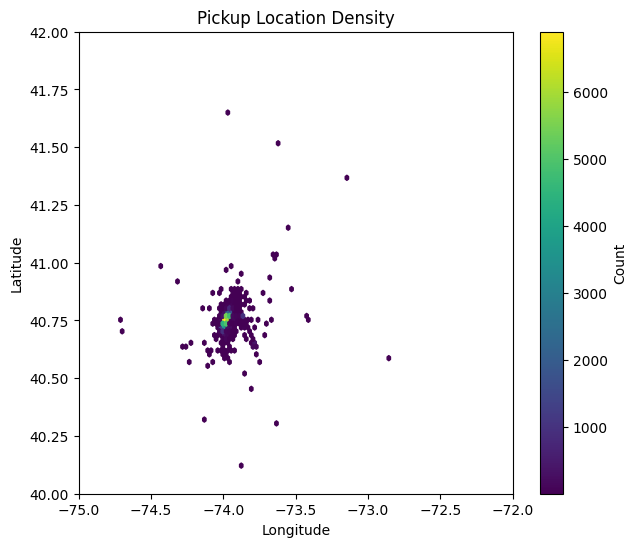

In [56]:
plt.figure(figsize=(7,6))
hb = plt.hexbin(eda["pickup_longitude"], eda["pickup_latitude"], gridsize=80, mincnt=1)
plt.title("Pickup Location Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(nyc_lon_min, nyc_lon_max)
plt.ylim(nyc_lat_min, nyc_lat_max)
cb = plt.colorbar(hb)
cb.set_label("Count")
save_and_show_current_figure("/content/pickup_density.png")

-----

-----

In [57]:
#  Prepare data

In [58]:
FEATURES = ["distance_miles", "passenger_count", "hour_of_day", "day_of_week", "month"]

In [59]:
TARGET   = "fare_amount"

In [60]:
X = eda[FEATURES]

In [61]:
y = eda[TARGET]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

-----

----

In [63]:
#  Train model

In [64]:
model = RandomForestRegressor(
    n_estimators=30,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

In [65]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=30,
                      n_jobs=-1, random_state=42)

------

-----

In [66]:
preds = model.predict(X_test)

In [67]:
rmse = float(np.sqrt(mean_squared_error(y_test, preds)))

In [68]:
print("Random Forest RMSE:", rmse)

Random Forest RMSE: 4.224761675354965


In [69]:
with open("/content/metrics.json", "w") as f:
    json.dump({"rmse": rmse}, f, indent=2)
print("Metrics saved to /content/metrics.json")

Metrics saved to /content/metrics.json


-----

------

In [70]:
#  Save model bundle

In [71]:
model_path = "/content/taxi_fare_model.joblib"

In [72]:
bundle = {"model": model, "features": FEATURES}

In [73]:
joblib.dump(bundle, model_path)

['/content/taxi_fare_model.joblib']

In [74]:
print("Model bundle saved to:", model_path)

Model bundle saved to: /content/taxi_fare_model.joblib


In [75]:
with open("/content/features.json", "w") as f:
    json.dump({"features": FEATURES}, f, indent=2)
print("Features saved to /content/features.json")

Features saved to /content/features.json


-----

------

In [76]:
#  Sanity check

In [77]:
reloaded = joblib.load(model_path)

In [78]:
reloaded_model = reloaded["model"]

In [79]:
reloaded_features = reloaded["features"]

In [80]:
print("Model type:", type(reloaded_model))
print("Features used for training:", reloaded_features)

Model type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Features used for training: ['distance_miles', 'passenger_count', 'hour_of_day', 'day_of_week', 'month']


In [81]:
sample_input = {
    "distance_miles": 3.5,
    "passenger_count": 2,
    "hour_of_day": 14,
    "day_of_week": 3,
    "month": 6
}

In [82]:
sample_df = pd.DataFrame([sample_input])[reloaded_features]

In [83]:
sample_pred = float(reloaded_model.predict(sample_df)[0])

In [84]:
print("Sample prediction dollars:", round(sample_pred, 2))

Sample prediction dollars: 16.68


------

-----

In [85]:
#  Save manifest

In [86]:
outputs = {
    "raw_csv": raw_csv_path,
    "clean_csv": clean_csv_path,
    "avg_fare_by_hour_csv": "/content/avg_fare_by_hour.csv",
    "avg_fare_by_dayofweek_csv": "/content/avg_fare_by_dayofweek.csv",
    "correlation_matrix_csv": "/content/correlation_matrix.csv",
    "plots": {
        "fare_distribution": "/content/fare_distribution.png",
        "passenger_count_distribution": "/content/passenger_count_distribution.png",
        "distance_distribution": "/content/distance_distribution.png",
        "fare_vs_distance": "/content/fare_vs_distance.png",
        "avg_fare_by_hour": "/content/avg_fare_by_hour.png",
        "avg_fare_by_day": "/content/avg_fare_by_day.png",
        "pickup_density": "/content/pickup_density.png"
    },
    "model": model_path,
    "features_json": "/content/features.json",
    "metrics_json": "/content/metrics.json"
}

In [87]:
with open("/content/outputs_manifest.json", "w") as f:
    json.dump(outputs, f, indent=2)

In [88]:
print("All artifacts saved flat in /content. Key paths:")
for k, v in outputs.items():
    print("-", k, ":", v if not isinstance(v, dict) else "[see plots dict]")

All artifacts saved flat in /content. Key paths:
- raw_csv : /content/train.csv
- clean_csv : /content/clean_taxi_data.csv
- avg_fare_by_hour_csv : /content/avg_fare_by_hour.csv
- avg_fare_by_dayofweek_csv : /content/avg_fare_by_dayofweek.csv
- correlation_matrix_csv : /content/correlation_matrix.csv
- plots : [see plots dict]
- model : /content/taxi_fare_model.joblib
- features_json : /content/features.json
- metrics_json : /content/metrics.json


-----

# END